In [2]:
import pandas as pd
import os

import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
# классификаторы
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
# метрики классификации
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score, roc_auc_score

import seaborn as sns

# 1. Скачайте данные по ссылке
https://www.kaggle.com/competitions/titanic/data?select=train.csv 

In [3]:
# имя файла с данными
data_file_dir = u"./data"
data_file_names = [os.path.join(data_file_dir, x) for x in os.listdir(data_file_dir)]
data_file_names

['./data/test.csv', './data/train.csv', './data/gender_submission.csv']

In [4]:
# данные и их структура
print("==Данные и их структура из файла train")
data = pd.read_csv(data_file_names[1])
print(data.shape)
print(data.info())
data.sample(7)

==Данные и их структура из файла train
(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
186,187,1,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,NaN,1,0,370365,15.5000,NaN,Q
379,380,0,3,"Gustafsson, Mr. Karl Gideon",male,19.0,0,0,347069,7.7750,NaN,S
634,635,0,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.9000,NaN,S
741,742,0,1,"Cavendish, Mr. Tyrell William",male,36.0,1,0,19877,78.8500,C46,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
710,711,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24.0,0,0,PC 17482,49.5042,C90,C
191,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S


In [5]:
# NaN мешают классификации - заменим их на 'none' , рабочая выборка немного сократиться. наверное, это не будет сильно критичным 

data.Cabin.unique()
data.Cabin.fillna('none', inplace=True)
data.Cabin.unique()

data.dropna(inplace=True)
data.shape

(712, 12)

In [6]:
# количество уникальных значений по каждому из признаков. Чем больше уникальных значений, тем потенциальнаее это свойство не надо брать в расчет модели
print(data.shape)
data.nunique()

(712, 12)


PassengerId    712
Survived         2
Pclass           3
Name           712
Sex              2
Age             88
SibSp            6
Parch            7
Ticket         541
Fare           219
Cabin          134
Embarked         3
dtype: int64

In [7]:
# баланс целевого признака 
data['Survived'].value_counts(normalize=True)

0    0.595506
1    0.404494
Name: Survived, dtype: float64

<AxesSubplot: >

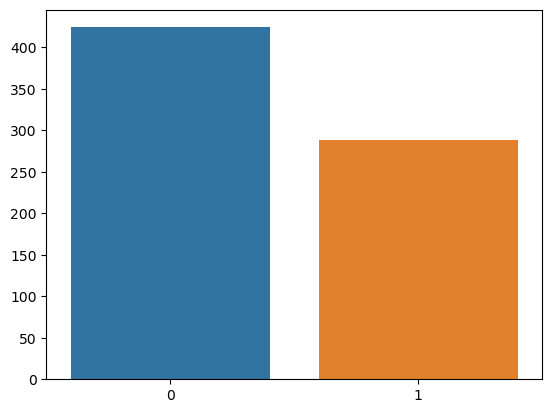

In [40]:
surv = data['Survived'].value_counts()
sns.barplot([[x] for x in surv.values])


<AxesSubplot: >

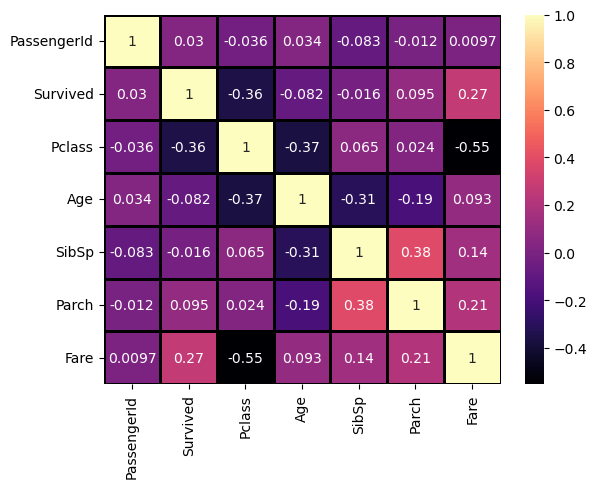

In [7]:
# интересные визуальные выовды, подсмотренные у коллег по цеху
sns.heatmap(data.corr(), cmap='magma', linewidths=2, linecolor='black', annot=True)

# 2. Исключите признаки, которые на ваш взгляд, могут привести к переобучению 
(например, id).

In [8]:
print("==Исходный набор признаков:")
features = data.columns
list(features)

==Исходный набор признаков:


['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [9]:
print("==Набор признаков для обучения:")
# 
good_features = \
[\
 # 'PassengerId', # номер 
 # 'Survived', # Выживание 0 = Нет, 1 = Да
 'Pclass', # Класс билета 1 = 1-й, 2 = 2-й, 3 = 3-й
 # 'Name',  # имя - 
 'Sex',    # пол
 'Age',    # возраст в годах
 'SibSp',   # Количество братьев и сестер / супругов на борту "Титаника"
 'Parch',   # Количество родителей / детей на борту "Титаника"
 # 'Ticket', # номер билета
 'Fare',  # тариф
 'Cabin', # номер каюты
 'Embarked' # Порт посадки C = Шербур, Q = Квинстаун, S = Саутгемптон
]

good_features

==Набор признаков для обучения:


['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']

# 3. Разделите выборку на train и test.

In [10]:
# признаки для обучения
X = data[good_features]
# целевой признак 
y = data['Survived']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=11)
print(X_train.shape)

(534, 8)


# 4. Преобразуйте признаки
 категориальные признаки с помощью sklearn.preprocessing.OneHotEncoder, 
 
 а некатегориальные с помощью sklearn.preprocessing.StandardScaler (на следующем занятии расскажем, зачем это нужно)

## Категориальные признаки

In [12]:
cat_features = \
[\
 # 'PassengerId', # номер 
 # 'Survived', # Выживание 0 = Нет, 1 = Да
 # 'Pclass', # Класс билета 1 = 1-й, 2 = 2-й, 3 = 3-й
 # 'Name',  # имя - 
 'Sex',    # пол
 # 'Age',    # возраст в годах
 # 'SibSp',   # Количество братьев и сестер / супругов на борту "Титаника"
 # 'Parch',   # Количество родителей / детей на борту "Титаника"
 # 'Ticket', # номер билета
 # 'Fare',  # тариф
 'Cabin', # номер каюты
 'Embarked' # Порт посадки C = Шербур, Q = Квинстаун, S = Саутгемптон
]
cat_features_scaled = [f+"_ohe" for f in cat_features]
cat_features_scaled

['Sex_ohe', 'Cabin_ohe', 'Embarked_ohe']

### Sex

In [13]:
# категориальные признаки с помощью sklearn.preprocessing.OneHotEncoder,
ohe = OneHotEncoder() #handle_unknown='error', drop='first' drop='if_binary'
sx=ohe.fit_transform(X_train['Sex'].values.reshape(-1,1) ).toarray()
columns = ['Sex_'+x for x in ohe.categories_[0]]
# т.к. признак бинарный - берем только один столбец 
df_sex = pd.DataFrame(sx, columns=columns).iloc[:,0].to_frame() #, columns=ohe.categories_
df_sex
# X_train = pd.concat([X_train,df_sex], axis=1)
# все преобразованные признаки складываем отдельно - на них будем тренировать модель
X_train_enc = df_sex
X_train_enc.sample(5)

# для тестового датасета
sx_t=ohe.fit_transform(X_test['Sex'].values.reshape(-1,1) ).toarray()
# columns = ['Sex_'+x for x in ohe.categories_[0]]
df_sex_t = pd.DataFrame(sx_t, columns=columns).iloc[:,0].to_frame() #, columns=ohe.categories_
# df_sex
# X_train = pd.concat([X_train,df_sex], axis=1)
X_test_enc = df_sex_t
# X_train_enc.sample(5)

### Embarked_

In [14]:
# категориальные признаки Embarked
ohe = OneHotEncoder() #handle_unknown='error', drop='first' drop='if_binary'
emb=ohe.fit_transform(X_train['Embarked'].values.reshape(-1,1) ).toarray()
columns=['Embarked_'+str(x) for x in list(ohe.categories_[0])]
df_emb = pd.DataFrame(emb, columns=columns)#.iloc[:,0].to_frame() #, columns=ohe.categories_
df_emb
X_train_enc = pd.concat([X_train_enc,df_emb], axis=1)
X_train_enc

# для тестового датасета
emb_t=ohe.fit_transform(X_test['Embarked'].values.reshape(-1,1) ).toarray()
# columns=['Embarked_'+str(x) for x in list(ohe.categories_[0])]
df_emb_t = pd.DataFrame(emb_t, columns=columns)#.iloc[:,0].to_frame() #, columns=ohe.categories_
# df_emb
X_test_enc = pd.concat([X_test_enc,df_emb_t], axis=1)
# X_test_enc

### Cabin

In [15]:
# # категориальные признаки Cabin - не будем его брать, тк в нем много пропусков 
# ohe = OneHotEncoder() #handle_unknown='error', drop='first' drop='if_binary'
# cab=ohe.fit_transform(X_train['Cabin'].values.reshape(-1,1) ).toarray()
# columns=['Cabin_'+str(x) for x in list(ohe.categories_[0])]
# df_cab = pd.DataFrame(cab, columns=columns)#.iloc[:,0].to_frame() #, columns=ohe.categories_
# df_cab
# X_train_enc = pd.concat([X_train_enc,df_cab], axis=1)
# X_train_enc


## Некатегориальные признаки

In [16]:
# удаляем пропущенные данные в поле Возраст
X_train.Age.unique()
# X_train.Age[X_train.Age == np.nan]
print(X_train.Age.dropna().shape)

# для тестового датасета
X_test.Age.unique()
# X_train.Age[X_train.Age == np.nan]
X_test.Age.dropna().shape

(534,)


(178,)

In [17]:
noncat_features = \
[\
 # 'PassengerId', # номер 
 # 'Survived', # Выживание 0 = Нет, 1 = Да
 'Pclass', # Класс билета 1 = 1-й, 2 = 2-й, 3 = 3-й
 # 'Name',  # имя - 
 # 'Sex',    # пол
 'Age',    # возраст в годах
 'SibSp',   # Количество братьев и сестер / супругов на борту "Титаника"
 'Parch',   # Количество родителей / детей на борту "Титаника"
 # 'Ticket', # номер билета
 'Fare',  # тариф
 # 'Cabin', # номер каюты
 # 'Embarked' # Порт посадки C = Шербур, Q = Квинстаун, S = Саутгемптон
]
noncat_features_scaled = [f+"_scaled" for f in noncat_features]
noncat_features_scaled

['Pclass_scaled', 'Age_scaled', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

In [18]:
scaler = StandardScaler()
X_train_enc[noncat_features_scaled] = scaler.fit_transform(X_train[noncat_features].values.reshape(-1,len(noncat_features)) )
X_train_enc

# для тестового датасета
X_test_enc[noncat_features_scaled] = scaler.fit_transform(X_test[noncat_features].values.reshape(-1,len(noncat_features)) )
X_test_enc


,Sex_female,Embarked_C,Embarked_Q,Embarked_S,Pclass_scaled,Age_scaled,SibSp_scaled,Parch_scaled,Fare_scaled
0,1.0,1.0,0.0,0.0,-1.404017,1.616298,0.681276,-0.532873,0.416903
1,0.0,0.0,0.0,1.0,0.964846,0.027723,-0.636845,-0.532873,-0.523717
2,1.0,1.0,0.0,0.0,-1.404017,0.061523,0.681276,-0.532873,1.403776
3,0.0,1.0,0.0,0.0,-1.404017,2.021892,0.681276,0.609915,0.779596
4,1.0,0.0,0.0,1.0,0.964846,-0.208873,-0.636845,0.609915,-0.442660
...,...,...,...,...,...,...,...,...,...
173,0.0,0.0,0.0,1.0,-0.219586,0.872710,0.681276,0.609915,-0.190332
174,0.0,0.0,0.0,1.0,-0.219586,-0.344071,0.681276,-0.532873,-0.194912
175,1.0,0.0,0.0,1.0,0.964846,-0.682066,-0.636845,-0.532873,-0.512497
176,1.0,0.0,0.0,1.0,-0.219586,0.940309,0.681276,-0.532873,-0.194912


# 5. Обучите модели логистической регрессии и KNN
, посчитайте все метрики классификации, которые были упомянуты на занятии, сделайте выводы.

In [19]:
Rez = {'Выводы':"?"}

## Логистическая регрессия


In [20]:
log_reg = LogisticRegression()
log_reg.fit(X_train_enc, y_train)

LogisticRegression()

### тренировочный датасет

In [21]:
y_pred_lg = log_reg.predict(X_train_enc)

In [22]:
print("Тренировочный датасет:")
# print("confusion_matrix:\n", confusion_matrix(y_train, y_pred_lg) )
# print("recall_score:\n", recall_score(y_train, y_pred_lg) )
# print("precision_score:\n", precision_score(y_train, y_pred_lg))
# print("accuracy_score:\n", accuracy_score(y_train, y_pred_lg) )
Rez['LogisticRegression'] = {'train': {'confusion_matrix' : confusion_matrix(y_train, y_pred_lg)
                                      , 'recall_score' : recall_score(y_train, y_pred_lg)
                                      , 'precision_score': precision_score(y_train, y_pred_lg)
                                      , 'accuracy_score' : accuracy_score(y_train, y_pred_lg)
                                      }
                            }
Rez

Тренировочный датасет:


{'Выводы': '?',
 'LogisticRegression': {'train': {'confusion_matrix': array([[290,  38],
          [ 61, 145]]),
   'recall_score': 0.7038834951456311,
   'precision_score': 0.7923497267759563,
   'accuracy_score': 0.8146067415730337}}}

<AxesSubplot: >

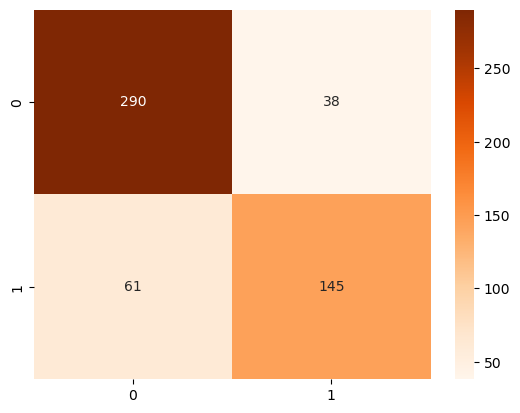

In [23]:
# интересные визуальные выводы, подсмотренные у коллег по цеху

sns.heatmap(Rez['LogisticRegression']['train']['confusion_matrix'], annot=True, cmap='Oranges', fmt='g')

### Тестовый датасет

In [24]:
y_pred_lg_t = log_reg.predict(X_test_enc)

In [25]:
print("Тестовый датасет:")
# print("confusion_matrix:\n", confusion_matrix(y_test, y_pred_lg_t) )
# print("recall_score:\n", recall_score(y_test, y_pred_lg_t) )
# print("precision_score:\n", precision_score(y_test, y_pred_lg_t))
# print("accuracy_score:\n", accuracy_score(y_test, y_pred_lg_t) )
Rez['LogisticRegression']['test'] =  {'confusion_matrix' : confusion_matrix(y_test, y_pred_lg_t)
                                      , 'recall_score' : recall_score(y_test, y_pred_lg_t)
                                      , 'precision_score': precision_score(y_test, y_pred_lg_t)
                                      , 'accuracy_score' : accuracy_score(y_test, y_pred_lg_t) 
                                    }
                            
Rez

Тестовый датасет:


{'Выводы': '?',
 'LogisticRegression': {'train': {'confusion_matrix': array([[290,  38],
          [ 61, 145]]),
   'recall_score': 0.7038834951456311,
   'precision_score': 0.7923497267759563,
   'accuracy_score': 0.8146067415730337},
  'test': {'confusion_matrix': array([[82, 14],
          [24, 58]]),
   'recall_score': 0.7073170731707317,
   'precision_score': 0.8055555555555556,
   'accuracy_score': 0.7865168539325843}}}

## KNN

In [26]:
knn = KNeighborsClassifier()
knn.fit(X_train_enc, y_train)

KNeighborsClassifier()

### тренировочный датасет

In [27]:
y_pred = knn.predict(X_train_enc)

In [28]:
print("Тренировочный датасет:")
# print("confusion_matrix:\n", confusion_matrix(y_train, y_pred) )
# print("recall_score:\n", recall_score(y_train, y_pred) )
# print("precision_score:\n", precision_score(y_train, y_pred))
# print("accuracy_score:\n", accuracy_score(y_train, y_pred) )
Rez['KNeighborsClassifier'] = {'train':  
                                           {'confusion_matrix' : confusion_matrix(y_train, y_pred)
                                          , 'recall_score' : recall_score(y_train, y_pred)
                                          , 'precision_score': precision_score(y_train, y_pred)
                                          , 'accuracy_score' : accuracy_score(y_train, y_pred) 
                                           }
                                      }
                            
Rez

Тренировочный датасет:


{'Выводы': '?',
 'LogisticRegression': {'train': {'confusion_matrix': array([[290,  38],
          [ 61, 145]]),
   'recall_score': 0.7038834951456311,
   'precision_score': 0.7923497267759563,
   'accuracy_score': 0.8146067415730337},
  'test': {'confusion_matrix': array([[82, 14],
          [24, 58]]),
   'recall_score': 0.7073170731707317,
   'precision_score': 0.8055555555555556,
   'accuracy_score': 0.7865168539325843}},
 'KNeighborsClassifier': {'train': {'confusion_matrix': array([[295,  33],
          [ 51, 155]]),
   'recall_score': 0.7524271844660194,
   'precision_score': 0.824468085106383,
   'accuracy_score': 0.8426966292134831}}}

### Тестовый датасет

In [29]:
y_pred_t = knn.predict(X_test_enc)

In [30]:
print("Тестовый датасет:")
# print("confusion_matrix:\n", confusion_matrix(y_test, y_pred_t) )
# print("recall_score:\n", recall_score(y_test, y_pred_t) )
# print("precision_score:\n", precision_score(y_test, y_pred_t))
# print("accuracy_score:\n", accuracy_score(y_test, y_pred_t) )
Rez['KNeighborsClassifier']['test'] =  {'confusion_matrix' : confusion_matrix(y_test, y_pred_t)
                                          , 'recall_score' : recall_score(y_test, y_pred_t)
                                          , 'precision_score': precision_score(y_test, y_pred_t)
                                          , 'accuracy_score' : accuracy_score(y_test, y_pred_t) 
                                           }
Rez

Тестовый датасет:


{'Выводы': '?',
 'LogisticRegression': {'train': {'confusion_matrix': array([[290,  38],
          [ 61, 145]]),
   'recall_score': 0.7038834951456311,
   'precision_score': 0.7923497267759563,
   'accuracy_score': 0.8146067415730337},
  'test': {'confusion_matrix': array([[82, 14],
          [24, 58]]),
   'recall_score': 0.7073170731707317,
   'precision_score': 0.8055555555555556,
   'accuracy_score': 0.7865168539325843}},
 'KNeighborsClassifier': {'train': {'confusion_matrix': array([[295,  33],
          [ 51, 155]]),
   'recall_score': 0.7524271844660194,
   'precision_score': 0.824468085106383,
   'accuracy_score': 0.8426966292134831},
  'test': {'confusion_matrix': array([[85, 11],
          [23, 59]]),
   'recall_score': 0.7195121951219512,
   'precision_score': 0.8428571428571429,
   'accuracy_score': 0.8089887640449438}}}

# Расчет метрик - Более компактный формат 

In [31]:
# логистическая регрессия
log_reg = LogisticRegression()
log_reg.fit(X_train_enc, y_train)
# КНН
knn = KNeighborsClassifier()
knn.fit(X_train_enc, y_train)

Rez = {'LogisticRegression':dict(), 'KNeighborsClassifier':dict()}

for classifier in [log_reg, knn]:
    # название метода 
    cls_name = str(type(classifier)).replace("'>","").split(".")[-1]
    
    # цикл по тренировочным и теостовым данным
    for X,y,label in zip([X_train_enc, X_test_enc], [y_train, y_test], ['train', 'test']):
        # предсказания модели
        y_pred = classifier.predict(X)
    
        Rez[cls_name][label] = {'confusion_matrix' : confusion_matrix(y, y_pred)
                              , 'recall_score' : recall_score(y, y_pred)
                              , 'precision_score': precision_score(y, y_pred)
                              , 'accuracy_score' : accuracy_score(y, y_pred)
                              , 'f1_score' : f1_score(y, y_pred)
                              , 'roc_auc_score' : roc_auc_score(y, y_pred)
                              }
    
Rez
    

{'LogisticRegression': {'train': {'confusion_matrix': array([[290,  38],
          [ 61, 145]]),
   'recall_score': 0.7038834951456311,
   'precision_score': 0.7923497267759563,
   'accuracy_score': 0.8146067415730337,
   'f1_score': 0.7455012853470437,
   'roc_auc_score': 0.7940149183045229},
  'test': {'confusion_matrix': array([[82, 14],
          [24, 58]]),
   'recall_score': 0.7073170731707317,
   'precision_score': 0.8055555555555556,
   'accuracy_score': 0.7865168539325843,
   'f1_score': 0.7532467532467532,
   'roc_auc_score': 0.7807418699186992}},
 'KNeighborsClassifier': {'train': {'confusion_matrix': array([[295,  33],
          [ 51, 155]]),
   'recall_score': 0.7524271844660194,
   'precision_score': 0.824468085106383,
   'accuracy_score': 0.8426966292134831,
   'f1_score': 0.7868020304568528,
   'roc_auc_score': 0.8259087141842292},
  'test': {'confusion_matrix': array([[85, 11],
          [23, 59]]),
   'recall_score': 0.7195121951219512,
   'precision_score': 0.8428571

# Выводы

In [32]:
# df_Rez = pd.json_normalize(Rez['LogisticRegression'] )
# df_Rez = pd.json_normalize(Rez )
df_Rez_log = pd.DataFrame(Rez['LogisticRegression'])
df_Rez_Knn = pd.DataFrame(Rez['KNeighborsClassifier'])
# разница между лог и knn
df_ = df_Rez_log - df_Rez_Knn
df_Rez_log.rename(columns={'test':'log.test', 'train':'log.train'}, inplace=True)
df_Rez_Knn.rename(columns={'test':'knn.test', 'train':'knn.train'}, inplace=True)
df_Rez = pd.concat([df_Rez_log, df_Rez_Knn], axis=1 )
df_Rez[['log.train', 'knn.train', 'log.test', 'knn.test']]


,log.train,knn.train,log.test,knn.test
confusion_matrix,"[[290, 38], [61, 145]]","[[295, 33], [51, 155]]","[[82, 14], [24, 58]]","[[85, 11], [23, 59]]"
recall_score,0.703883,0.752427,0.707317,0.719512
precision_score,0.79235,0.824468,0.805556,0.842857
accuracy_score,0.814607,0.842697,0.786517,0.808989
f1_score,0.745501,0.786802,0.753247,0.776316
roc_auc_score,0.794015,0.825909,0.780742,0.802464


In [33]:
print("Разность метрик Log и KNN: лучшие результаты по всем пунктам показывает KNN")
df_.rename_axis("Дельта Log и KNN")

Разность метрик Log и KNN: лучшие результаты по всем пунктам показывает KNN


,train,test
Дельта Log и KNN,,
confusion_matrix,"[[-5, 5], [10, -10]]","[[-3, 3], [1, -1]]"
recall_score,-0.048544,-0.012195
precision_score,-0.032118,-0.037302
accuracy_score,-0.02809,-0.022472
f1_score,-0.041301,-0.023069
roc_auc_score,-0.031894,-0.021723


In [34]:
print("""Разность метрик метрик KNN для наборов train и test: 
        в целом конечно же лучше результаты на test, т.к. на этих данных проходило обучение.
        Но вот precision лучше на выборке test.
      """)
(
    df_Rez[['knn.train']].rename(columns={"knn.train":"knn"}) - df_Rez[['knn.test']].rename(columns={"knn.test":"knn"})
).rename_axis("дельта Train и Test")

Разность метрик метрик KNN для наборов train и test: 
        в целом конечно же лучше результаты на test, т.к. на этих данных проходило обучение.
        Но вот precision лучше на выборке test.
      


,knn
дельта Train и Test,
confusion_matrix,"[[210, 22], [28, 96]]"
recall_score,0.032915
precision_score,-0.018389
accuracy_score,0.033708
f1_score,0.010486
roc_auc_score,0.023444


*=======================================================================*

Выводы:
1. По всем метрикам алгоритм KNN продемонстировал лучшие показатели.

2. В целом метрики на тестовых данных являются удовлетворительными, т.к. вероятность правильных прогнозов колеблется в районе 80%

3. Метрики для тренировочных данных немного лучше, чем метрики для тестовой выборки.





# 6. Подберите гиперпараметры 
для обоих моделей с помощью RandomizedSearchCV,

напишите, почему, как вы думаете, эти параметры подошли.

## Логистическая регрессия

In [35]:
params_log = {
    'penalty' : [ 'l2', None] #, 'elasticnet' , None 'l1',
    ,'class_weight' : ['balanced', None]
    , 'solver' : ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'] #, 'liblinear'
    , 'multi_class' : ['auto', 'ovr', 'multinomial']
    , 'n_jobs' : [-1,1,2,3,4,5] #, None
}
log = LogisticRegression()
cv_log = RandomizedSearchCV(log, params_log)
cv_log.fit(X_train_enc, y_train)

/home/fedorov/anaconda3/envs/newconda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/fedorov/anaconda3/envs/newconda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/fedorov/anaconda3/envs/newconda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/fedorov/anaconda3/envs/newconda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/fedorov/anaconda3/envs/newconda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

RandomizedSearchCV(estimator=LogisticRegression(),
                   param_distributions={'class_weight': ['balanced', None],
                                        'multi_class': ['auto', 'ovr',
                                                        'multinomial'],
                                        'n_jobs': [-1, 1, 2, 3, 4, 5],
                                        'penalty': ['l2', None],
                                        'solver': ['lbfgs', 'newton-cg',
                                                   'newton-cholesky', 'sag',
                                                   'saga']})

In [36]:
cv_log.best_params_

{'solver': 'newton-cg',
 'penalty': 'l2',
 'n_jobs': 1,
 'multi_class': 'auto',
 'class_weight': None}

* ====================================================

Почему параметры подошли?

Параметры подошли, т.к. их значения перебирались из множества допустимых значений параметров классфикаторов

## KNN

In [37]:
# варианты параметров
params_knn = {
    'n_neighbors':range(1,50)
    , 'weights' : ['uniform', 'distance']
    , 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
    , 'leaf_size' : range(1,40)
    , 'p' : [1,2,3,4,5]
    , 'n_jobs' : [-1,1,2,3,4,5]
}

knn = KNeighborsClassifier()
cv_knn = RandomizedSearchCV(knn, params_knn)
cv_knn.fit(X_train_enc, y_train)

RandomizedSearchCV(estimator=KNeighborsClassifier(),
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': range(1, 40),
                                        'n_jobs': [-1, 1, 2, 3, 4, 5],
                                        'n_neighbors': range(1, 50),
                                        'p': [1, 2, 3, 4, 5],
                                        'weights': ['uniform', 'distance']})

In [38]:
# лучшее сочетание параметров
cv_knn.best_params_

{'weights': 'uniform',
 'p': 1,
 'n_neighbors': 36,
 'n_jobs': -1,
 'leaf_size': 4,
 'algorithm': 'brute'}

# 7. Посчитайте метрики для новых моделей
, также сделайте выводы.

In [39]:
# логистическая регрессия
log_reg = LogisticRegression(**cv_log.best_params_)
log_reg.fit(X_train_enc, y_train)
# КНН
knn = KNeighborsClassifier(**cv_knn.best_params_)
knn.fit(X_train_enc, y_train)

Rez_best = {'LogisticRegression':dict(), 'KNeighborsClassifier':dict()}

for classifier in [log_reg, knn]:
    # название метода 
    cls_name = str(type(classifier)).replace("'>","").split(".")[-1]
    
    # цикл по тренировочным и теостовым данным
    for X,y,label in zip([X_train_enc, X_test_enc], [y_train, y_test], ['train', 'test']):
        # предсказания модели
        y_pred = classifier.predict(X)
    
        Rez_best[cls_name][label] = {'confusion_matrix' : confusion_matrix(y, y_pred)
                              , 'recall_score' : recall_score(y, y_pred)
                              , 'precision_score': precision_score(y, y_pred)
                              , 'accuracy_score' : accuracy_score(y, y_pred) 
                              , 'f1_score' : f1_score(y, y_pred)
                              , 'roc_auc_score' : roc_auc_score(y, y_pred)
                              }
    
Rez_best
    

{'LogisticRegression': {'train': {'confusion_matrix': array([[290,  38],
          [ 61, 145]]),
   'recall_score': 0.7038834951456311,
   'precision_score': 0.7923497267759563,
   'accuracy_score': 0.8146067415730337,
   'f1_score': 0.7455012853470437,
   'roc_auc_score': 0.7940149183045229},
  'test': {'confusion_matrix': array([[82, 14],
          [24, 58]]),
   'recall_score': 0.7073170731707317,
   'precision_score': 0.8055555555555556,
   'accuracy_score': 0.7865168539325843,
   'f1_score': 0.7532467532467532,
   'roc_auc_score': 0.7807418699186992}},
 'KNeighborsClassifier': {'train': {'confusion_matrix': array([[303,  25],
          [ 81, 125]]),
   'recall_score': 0.6067961165048543,
   'precision_score': 0.8333333333333334,
   'accuracy_score': 0.8014981273408239,
   'f1_score': 0.7022471910112359,
   'roc_auc_score': 0.7652883021548662},
  'test': {'confusion_matrix': array([[90,  6],
          [32, 50]]),
   'recall_score': 0.6097560975609756,
   'precision_score': 0.892857

# Выводы

In [40]:
# df_Rez = pd.json_normalize(Rez['LogisticRegression'] )
# df_Rez = pd.json_normalize(Rez )
df_Rez_log_best = pd.DataFrame(Rez_best['LogisticRegression'])
df_Rez_Knn_best = pd.DataFrame(Rez_best['KNeighborsClassifier'])
df_Rez_log_best.rename(columns={'test':'log.test', 'train':'log.train'}, inplace=True)
df_Rez_Knn_best.rename(columns={'test':'knn.test', 'train':'knn.train'}, inplace=True)
df_Rez_best = pd.concat([df_Rez_log_best, df_Rez_Knn_best], axis=1 )
print("==Метрики для моделей с подобранными лучшими параметрами")
df_Rez_best#[['log.train', 'knn.train', 'log.test', 'knn.test']]


==Метрики для моделей с подобранными лучшими параметрами


,log.train,log.test,knn.train,knn.test
confusion_matrix,"[[290, 38], [61, 145]]","[[82, 14], [24, 58]]","[[303, 25], [81, 125]]","[[90, 6], [32, 50]]"
recall_score,0.703883,0.707317,0.606796,0.609756
precision_score,0.79235,0.805556,0.833333,0.892857
accuracy_score,0.814607,0.786517,0.801498,0.786517
f1_score,0.745501,0.753247,0.702247,0.724638
roc_auc_score,0.794015,0.780742,0.765288,0.773628


In [41]:
# print("==Метрики для моделей с параметрами по умолчанию ")
df_Rez#[['log.train', 'knn.train', 'log.test', 'knn.test']]

print("==Разность метрик моделей с лучшими параметрами и моделей с  параметрами по умолчанию ")
df_Rez_best - df_Rez

==Разность метрик моделей с лучшими параметрами и моделей с  параметрами по умолчанию 


,log.train,log.test,knn.train,knn.test
confusion_matrix,"[[0, 0], [0, 0]]","[[0, 0], [0, 0]]","[[8, -8], [30, -30]]","[[5, -5], [9, -9]]"
recall_score,0.0,0.0,-0.145631,-0.109756
precision_score,0.0,0.0,0.008865,0.05
accuracy_score,0.0,0.0,-0.041199,-0.022472
f1_score,0.0,0.0,-0.084555,-0.051678
roc_auc_score,0.0,0.0,-0.06062,-0.028836


*=========================================================*

4. Добавил недостающие метрики классификации: f-1, roc-auc
По всем метрикам KNN на модели с лучшими найденными гиперпараметрами лидирует. Особенно это видно на тестовом наборе.
После каких-то кооректировок вдруг оказалось, что precision на тестовых данных вообще стало больше 90%
Получается, что подбор гиперпараметров это очень эффективный инструмент.
И подготовка датасета тоже играет большую роль. Оставление одного лишь столбца по признаку "Sex" (до этого было два male female) немного улучшило показатели KNN.


3. Небольшие измнения в поиске гиперпараметров и показатели моделей уже совсем другие.

KNN на лучших гиперпараметрах почему-то ухудшился относительно модели с параметрами по умолчанию

recall  вообще упал ниже 70%

Вывод один: лучшее - враг хорошего. 

====

1. Модель KNN продолжает оставаться быть лучшей

2. С подобранными гиперпараметрами модель Логистической регрессии не изменила свои метрики,
а модель KNN немногим стала лучше по метрике precision и по одному проценту потеряла на остальных метриках

# GIT